<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step1_create_annotation_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPoseKit Step 1 - Create an annotation set

This is step 1 of the example notebooks for using DeepPoseKit. This notebook shows you how to load and sample images from a video, define a keypoint skeleton, and save the data to a file for labelling with keypoints.


**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

If you haven't already installed DeepPoseKit you can run the next cell

In [ ]:
import sys
!{sys.executable} -m pip install -U deepposekit

In [1]:
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
from deepposekit.io import VideoReader, DataGenerator, initialize_dataset
from deepposekit.annotate import KMeansSampler
import tqdm
import glob
import pandas as pd

from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

# A note on image resolutions

Currently DeepPoseKit only supports image resolutions that can be repeatedly divided by 2. For example, all of these values are valid image resolutions for either height or width:

In [2]:
exp = np.arange(1,12)
exp = 2**exp

print(1*exp)
print(3*exp)
print(5*exp)
print(7*exp)
print(11*exp)

[   2    4    8   16   32   64  128  256  512 1024 2048]
[   6   12   24   48   96  192  384  768 1536 3072 6144]
[   10    20    40    80   160   320   640  1280  2560  5120 10240]
[   14    28    56   112   224   448   896  1792  3584  7168 14336]
[   22    44    88   176   352   704  1408  2816  5632 11264 22528]


Images that do not match these resolutions must be manually resized, cropped, or padded. We are working to add automated image size adjustments.

# Open a video
The `VideoReader` class allows you to load in single video frames or batches of frames from nearly any video format.

In [5]:
videos = glob.glob(HOME + '/Videos/*.mp4')
videos

['/home/urs/Videos/spider.mp4']

In [6]:
reader = VideoReader(HOME + '/Videos/spider.mp4', gray=False)
frame = reader[0] # read a frame
reader.close()
frame.shape

(1, 480, 640, 3)

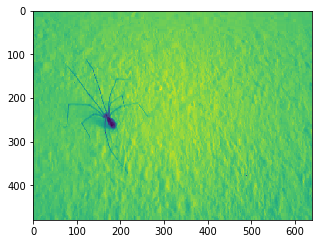

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(frame[0,...,0])
plt.show()

# Sample video frames
This loads batches of 100 frames from the video, and then randomly samples frames from the batches to hold them in memory. You can use any method for sampling frames.

In [6]:
reader = VideoReader(HOME + '/Videos/spider.mp4', batch_size=100, gray=False)

randomly_sampled_frames = []
for idx in tqdm.tqdm(range(len(reader)-1)):
    batch = reader[idx]
    random_sample = batch[np.random.choice(batch.shape[0], 10, replace=False)]
    randomly_sampled_frames.append(random_sample)
reader.close()

randomly_sampled_frames = np.concatenate(randomly_sampled_frames)
randomly_sampled_frames.shape

100%|██████████| 337/337 [00:05<00:00, 56.28it/s]


(3370, 192, 192, 1)

# Apply k-means to reduce correlation

This applies the k-means algorithm to the images using `KMeansSampler` to even out sampling across the distribution of images and reduce correlation within the annotation set.

In [7]:
kmeans = KMeansSampler(n_clusters=10, max_iter=1000, n_init=10, batch_size=100, verbose=True)
kmeans.fit(randomly_sampled_frames)

Init 1/10 with method: k-means++
Inertia for init 1/10: 2688081416.555160
Init 2/10 with method: k-means++
Inertia for init 2/10: 2628929362.453952
Init 3/10 with method: k-means++
Inertia for init 3/10: 2534230427.674422
Init 4/10 with method: k-means++
Inertia for init 4/10: 2682929717.041774
Init 5/10 with method: k-means++
Inertia for init 5/10: 2643379319.790725
Init 6/10 with method: k-means++
Inertia for init 6/10: 2539472724.223641
Init 7/10 with method: k-means++
Inertia for init 7/10: 2476257974.274304
Init 8/10 with method: k-means++
Inertia for init 8/10: 2657250544.953892
Init 9/10 with method: k-means++
Inertia for init 9/10: 2710801906.379192
Init 10/10 with method: k-means++
Inertia for init 10/10: 2578839167.316062
Minibatch iteration 1/34000: mean batch inertia: 8853646.313642, ewa inertia: 8853646.313642 
Minibatch iteration 2/34000: mean batch inertia: 9133489.364303, ewa inertia: 8870249.283126 
Minibatch iteration 3/34000: mean batch inertia: 9079500.987189, ewa i

KMeansSampler(batch_size=100, compute_labels=True, init='k-means++',
              init_size=None, max_iter=1000, max_no_improvement=10,
              n_clusters=10, n_init=10, random_state=None,
              reassignment_ratio=0.01, tol=0.0, verbose=True)

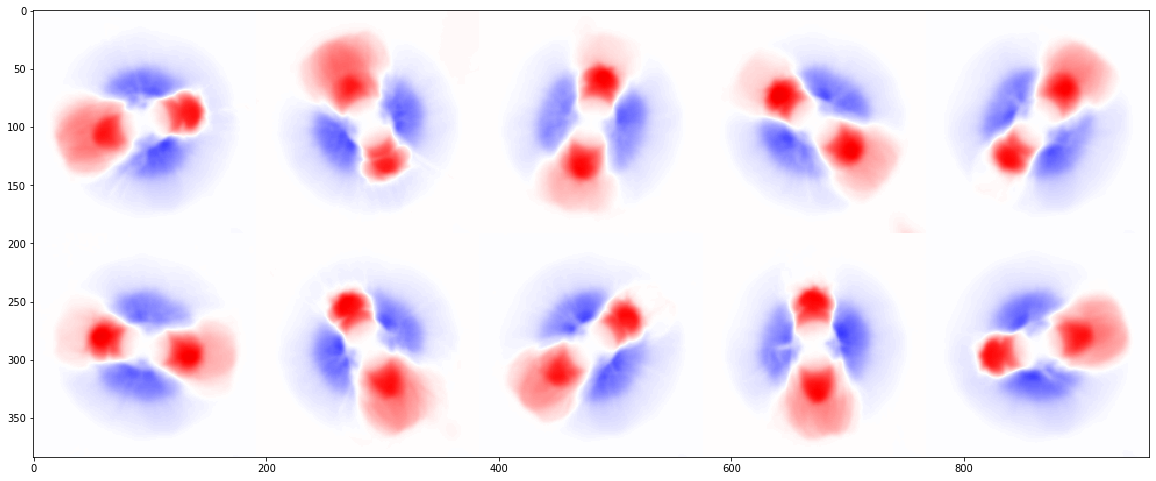

In [8]:
kmeans.plot_centers(n_rows=2)
plt.show()

In [9]:
kmeans_sampled_frames, kmeans_cluster_labels = kmeans.sample_data(randomly_sampled_frames, n_samples_per_label=10)
kmeans_sampled_frames.shape

Computing label assignment and total inertia
Computing label assignment and total inertia


(100, 192, 192, 1)

# Define a keypoints skeleton file
You must create a .xlsx or .csv file with keypoint names, parent relationships, and swapping relationships for bilaterally symmetric parts (only relevant if using flipping augmentations). If you leave out the `parent` and `swap` columns, then these will simply not be used for annotating data and training the model.

See example skeleton.csv files for more details


In [10]:
skeleton = pd.read_csv(HOME + '/deepposekit-data/datasets/fly/skeleton.csv')
skeleton

,name,parent,swap
0,head,NaN,NaN
1,eyeL,head,eyeR
2,eyeR,head,eyeL
3,neck,head,NaN
4,thorax,neck,NaN
5,abdomen,thorax,NaN
6,forelegR1,NaN,forelegL1
7,forelegR2,forelegR1,forelegL2
8,forelegR3,forelegR2,forelegL3
9,forelegR4,forelegR3,forelegL4


# Initialize a new data set for annotations

You can use any method for sampling images to create a numpy array with the shape (n_images, height, width, channels) and then initialize an annotation set. Check the doc string for more details:

In [11]:
initialize_dataset?

In [15]:
initialize_dataset(
    images=kmeans_sampled_frames,
    datapath=HOME + '/deepposekit-data/datasets/fly/example_annotation_set.h5',
    skeleton=HOME + '/deepposekit-data/datasets/fly/skeleton.csv',
    # overwrite=True # This overwrites the existing datapath
)

# Create a data generator
This creates a `DataGenerator` for loading annotated data. Indexing the generator returns an image-keypoints pair, which you can then visualize. Right now all the keypoints are set to zero, because they haven't been annotated.

You can also look at the doc string for more explanation:

In [16]:
DataGenerator?

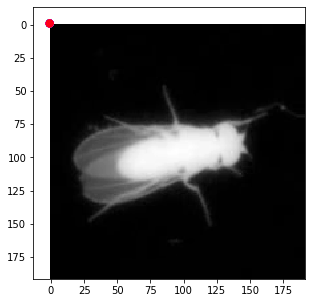

In [17]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/fly/example_annotation_set.h5', mode="full")

image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()